In [53]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)      

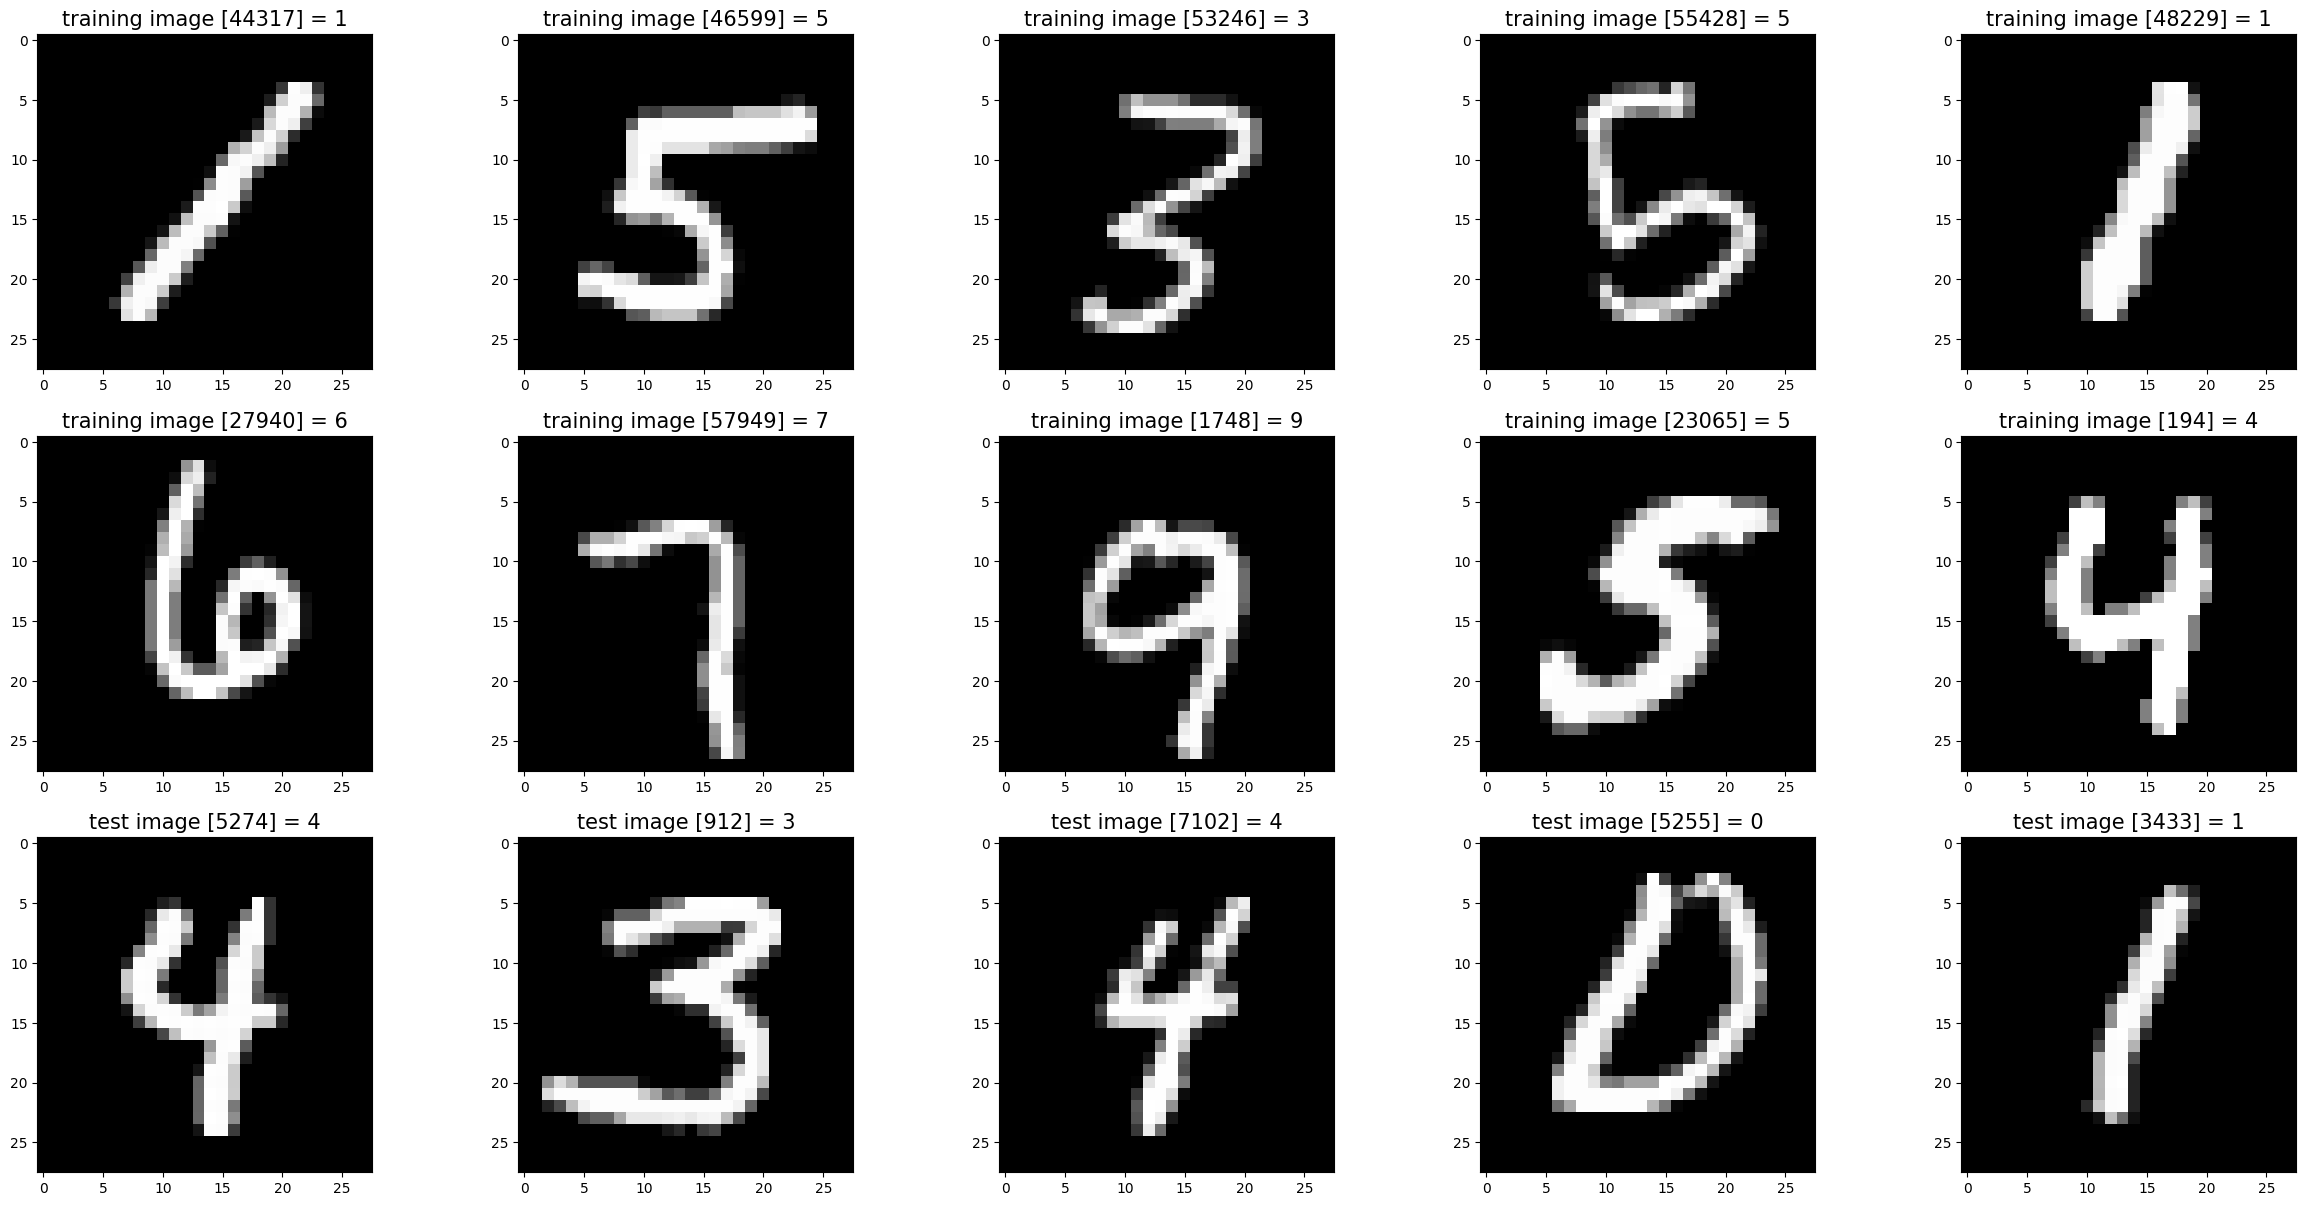

In [54]:
#
# Verify Reading Dataset via MnistDataloader class
#
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '.'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
    plt.show()

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [55]:
class LinearLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        # he initialization
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.biases = np.zeros((1, output_size))

    def forward(self, x):
        return np.dot(x, self.weights) + self.biases

    def backward(self, x, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(x.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        return grad_input, grad_weights, grad_biases
    
class ReLULayer:
    def forward(self, x):
        self.input = x
        self.output = np.maximum(0, x)
        return self.output

    def backward(self, grad_output):
        return grad_output * (self.input > 0)
    
class SoftmaxLayer:
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, y_true):
        grad_output = self.output.copy()
        grad_output[np.arange(len(y_true)), y_true] -= 1
        return grad_output / len(y_true)
    
class CrossEntropyLoss:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return -np.mean(np.log(y_pred[np.arange(len(y_true)), y_true] + 1e-15))

    def backward(self):
        grad_output = self.y_pred.copy()
        grad_output[np.arange(len(self.y_true)), self.y_true] -= 1
        return grad_output / len(self.y_true)

In [56]:
class NeuralNetwork:
    def __init__(self, layers):
     self.layers = layers
     self.W1 = LinearLayer(784, 128)
     self.activation1 = ReLULayer()
     self.W2 = LinearLayer(128, 10)
     self.softmax = SoftmaxLayer()
     self.activation2 = SoftmaxLayer()
     self.loss = CrossEntropyLoss()

    def forward(self, x):
        self.input = x
        out = self.W1.forward(x)
        out = self.activation1.forward(out)
        out = self.W2.forward(out)
        out = self.activation2.forward(out)
        self.softmax.forward(out)
        return out
    
    def backward(self, y_true, learning_rate):
        grad = self.softmax.backward(y_true)
        grad, grad_W2, grad_b2 = self.W2.backward(self.activation1.output, grad)
        grad = self.activation1.backward(grad)
        grad, grad_W1, grad_b1 = self.W1.backward(self.input, grad)
        # Update weights and biases
        self.W2.weights -= learning_rate * grad_W2
        self.W2.biases -= learning_rate * grad_b2
        self.W1.weights -= learning_rate * grad_W1
        self.W1.biases -= learning_rate * grad_b1

In [57]:
# Initalize and train the neural network
nn = NeuralNetwork(layers=[])
learning_rate = 0.1
num_epochs = 20
batch_size = 64

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


x_train_normalized = np.array(x_train).reshape(-1, 28*28) / 255.0
x_train_flattened = x_train_normalized.reshape(x_train_normalized.shape[0], -1)
y_train_array = np.array(y_train, dtype=np.int64)

m = x_train_flattened.shape[0]

losses = []
accurities = []

for epoch in range(num_epochs):
    indices = np.arange(m)
    np.random.shuffle(indices)
    x_train_shuffled = x_train_flattened[indices]
    y_train_shuffled = y_train_array[indices]

    epoch_loss = 0


    for i in range(0, m, batch_size):
        x_batch = x_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size].astype(np.int64)

        predictions = nn.forward(x_batch)
        loss = nn.loss.forward(predictions, y_batch)
        epoch_loss += loss

        # compute gradient of the loss w.r.t. the predictions
        nn.backward(y_batch, learning_rate)

    #calculate accuracy
    full_predictions = nn.forward(x_train_flattened)
    predicted_classes = np.argmax(full_predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_train_array)

    awg_loss = epoch_loss / (m / batch_size)

    losses.append(awg_loss)
    accurities.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {awg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/20, Loss: 18.4974, Accuracy: 0.4423
Epoch 2/20, Loss: 21.0330, Accuracy: 0.4419
Epoch 2/20, Loss: 21.0330, Accuracy: 0.4419
Epoch 3/20, Loss: 21.0698, Accuracy: 0.3509
Epoch 3/20, Loss: 21.0698, Accuracy: 0.3509
Epoch 4/20, Loss: 21.0917, Accuracy: 0.3910
Epoch 4/20, Loss: 21.0917, Accuracy: 0.3910
Epoch 5/20, Loss: 21.0911, Accuracy: 0.4369
Epoch 5/20, Loss: 21.0911, Accuracy: 0.4369
Epoch 6/20, Loss: 20.9967, Accuracy: 0.3690
Epoch 6/20, Loss: 20.9967, Accuracy: 0.3690
Epoch 7/20, Loss: 20.9426, Accuracy: 0.4630
Epoch 7/20, Loss: 20.9426, Accuracy: 0.4630
Epoch 8/20, Loss: 20.8856, Accuracy: 0.4182
Epoch 8/20, Loss: 20.8856, Accuracy: 0.4182
Epoch 9/20, Loss: 20.8948, Accuracy: 0.3731
Epoch 9/20, Loss: 20.8948, Accuracy: 0.3731


C:\Users\omerg\AppData\Local\Temp\ipykernel_17672\2686772435.py:29: RuntimeWarning: overflow encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
C:\Users\omerg\AppData\Local\Temp\ipykernel_17672\2686772435.py:10: RuntimeWarning: overflow encountered in dot
  return np.dot(x, self.weights) + self.biases
C:\Users\omerg\AppData\Local\Temp\ipykernel_17672\2686772435.py:29: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))


Epoch 10/20, Loss: nan, Accuracy: 0.0987
Epoch 11/20, Loss: nan, Accuracy: 0.0987
Epoch 11/20, Loss: nan, Accuracy: 0.0987
Epoch 12/20, Loss: nan, Accuracy: 0.0987
Epoch 12/20, Loss: nan, Accuracy: 0.0987
Epoch 13/20, Loss: nan, Accuracy: 0.0987
Epoch 13/20, Loss: nan, Accuracy: 0.0987
Epoch 14/20, Loss: nan, Accuracy: 0.0987
Epoch 14/20, Loss: nan, Accuracy: 0.0987
Epoch 15/20, Loss: nan, Accuracy: 0.0987
Epoch 15/20, Loss: nan, Accuracy: 0.0987
Epoch 16/20, Loss: nan, Accuracy: 0.0987
Epoch 16/20, Loss: nan, Accuracy: 0.0987
Epoch 17/20, Loss: nan, Accuracy: 0.0987
Epoch 17/20, Loss: nan, Accuracy: 0.0987
Epoch 18/20, Loss: nan, Accuracy: 0.0987
Epoch 18/20, Loss: nan, Accuracy: 0.0987
Epoch 19/20, Loss: nan, Accuracy: 0.0987
Epoch 19/20, Loss: nan, Accuracy: 0.0987
Epoch 20/20, Loss: nan, Accuracy: 0.0987
Epoch 20/20, Loss: nan, Accuracy: 0.0987
